# PredictorNotebook

### Dependencies

In [1]:
import pandas as pd
from modules.one_hot import one_hot
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn import ensemble
from sklearn import linear_model
from sklearn import neighbors

pd.set_option('display.max_columns', 100)

### Main

In [2]:
# Genres Dataframes
hiphop = pd.read_csv('GenresDatasetGenerator/Genres/HipHopGenre.csv')
rock = pd.read_csv('GenresDatasetGenerator/Genres/RockGenre.csv')
classical = pd.read_csv('GenresDatasetGenerator/Genres/ClassicalGenre.csv')
electronic = pd.read_csv('GenresDatasetGenerator/Genres/ElectronicGenre.csv')
alternative = pd.read_csv('GenresDatasetGenerator/Genres/AlternativeGenre.csv')
pop = pd.read_csv('GenresDatasetGenerator/Genres/PopGenre.csv')

# Combine genre dataframes into a list
genres = [hiphop, rock, classical, electronic, alternative, pop]

def prepare_data(genres):
    """
    prepare_data() generates necessary data as an input to a model.
    
    Args:
    - genres: a list of dataframes with features for every genre
    
    Returns:
    - samples: an array with input samples to a model
    - target: an array with output target to a model
    - nn_dataframe: input/output dataframe
    - target_dict: Encoded/Decoded target dictionary
    """
    
    # Feature columns used as input to a model
    ready_cols = ['danceability', 'energy', 'speechiness',
                  'acousticness', 'instrumentalness', 'liveness', 'valence']
    nready_cols = ['loudness', 'tempo', 'duration_ms',
                   'key', 'mode', 'time_signature']
    
    # Concatenate all dataframes and reset indexes
    df = pd.concat(genres, ignore_index=True).set_index('Track URI')
    ready_cols_df = df[ready_cols].reset_index()
    nready_cols_df = df[nready_cols]
    
    # Normalization objects
    scaler = MinMaxScaler()
    encoder = LabelEncoder()
    
    # Normalize features
    nready_cols_scaled = scaler.fit_transform(nready_cols_df.values)
    nready_cols_scaled_df = pd.DataFrame(nready_cols_scaled, columns=nready_cols)
    
    # Input to a model
    samples_df = pd.concat([ready_cols_df.drop(columns='Track URI'), nready_cols_scaled_df], axis=1)
    samples = samples_df.values
    
    # Target output from a model
    target = encoder.fit_transform(df['genres'].values)
    target_df = pd.DataFrame(target, columns=['genres'])
    
    # Target dictionary
    encoded_target = encoder.inverse_transform(target)
    target_dict = dict(zip(encoded_target, target))
    target_dict = dict(sorted(target_dict.items()))
    
    # Dataframe representation
    nn_dataframe = pd.concat([samples_df, target_df], axis=1)
    
    return samples, target, nn_dataframe, target_dict

# Call the function and assign the returned values
samples, target, nn_dataframe, target_dict = prepare_data(genres)

In [3]:
#Split dataset
X_train, X_test, y_train, y_test = train_test_split(samples, target, test_size = 0.2)

# ML Algorithms


## (1) Decision Trees

### GridSearchCV

In [4]:
def DecisionTreeGridSearch(X_train, y_train):
    #Parameters for GridSearchCV
    parameters = {'criterion': ['gini', 'entropy'],
                  'max_depth': [None, 2, 4, 6, 8],
                  'max_features': [None, 'sqrt', 'log2', 0.2, 0.4, 0.6, 0.8],
                  'splitter': ['best', 'random']}
    #GridSearchCV
    clf = GridSearchCV(estimator = tree.DecisionTreeClassifier(),
                      param_grid = parameters,
                      cv = 5,
                      n_jobs = 5,
                      verbose = 1)
    clf = clf.fit(X_train, y_train)
    print(clf.best_params_)

DecisionTreeGridSearch(X_train, y_train)

Fitting 5 folds for each of 140 candidates, totalling 700 fits
{'criterion': 'entropy', 'max_depth': 8, 'max_features': None, 'splitter': 'best'}


### Decision Tree Classifier

In [16]:
def DecisionTreeClassifier(X_train, y_train, X_test, y_test):
    #DecisionTreeClassifier
    clf = tree.DecisionTreeClassifier(criterion = 'entropy', 
                                      max_depth = 4, 
                                      max_features = 0.6, 
                                      splitter = 'best')
    clf = clf.fit(X_train, y_train)
    #Prediction
    predictions = clf.predict(X_test)
    #Prediction accuracy
    print(accuracy_score(y_test, predictions))
    #Confusion matrix
    confusion_matrix_result = confusion_matrix(y_test, predictions)
    cm_vis = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_result, 
                                    display_labels = clf.classes_)
    cm_vis.plot()

0.5356589147286822


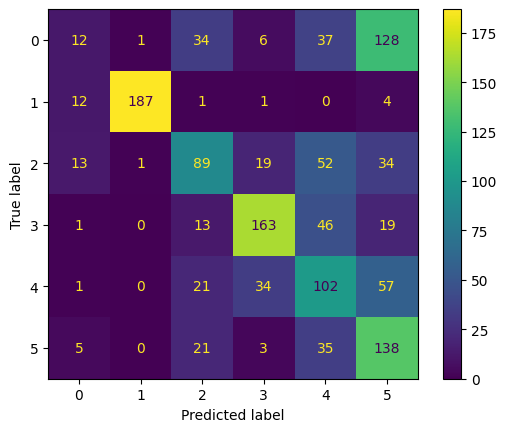

In [17]:
DecisionTreeClassifier(X_train, y_train, X_test, y_test)

## (2) Random Forests

### GridSearchCV

In [7]:
def RandomForestGridSearch(X_train, y_train):
    #Parameters for GridSearchCV
    parameters = {'max_depth': [None, 2, 4, 6, 8],
                  'max_features': [None, 'sqrt', 'log2', 0.2, 0.4, 0.6, 0.8]
                 }
    #GridSearchCV
    clf = GridSearchCV(estimator = ensemble.RandomForestClassifier(),
                       param_grid = parameters,
                       cv = 5,
                       n_jobs = 5,
                       verbose = 1)
    clf = clf.fit(X_train, y_train)
    print(clf.best_params_)

RandomForestGridSearch(X_train, y_train)

Fitting 5 folds for each of 35 candidates, totalling 175 fits
{'max_depth': 8, 'max_features': 0.2}


### Random Forest Classifier

In [8]:
def RandomForestClassifier(X_train, y_train, X_test, y_test):
    #RandomForestClassifier
    clf = ensemble.RandomForestClassifier()
    clf = clf.fit(X_train, y_train)
    #Prediction
    predictions = clf.predict(X_test)
    #Prediction accuracy
    print(accuracy_score(y_test, predictions))
    #Confusion matrix
    confusion_matrix_result = confusion_matrix(y_test, predictions)
    cm_vis = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_result, 
                                    display_labels = clf.classes_)
    cm_vis.plot()

0.6472868217054264


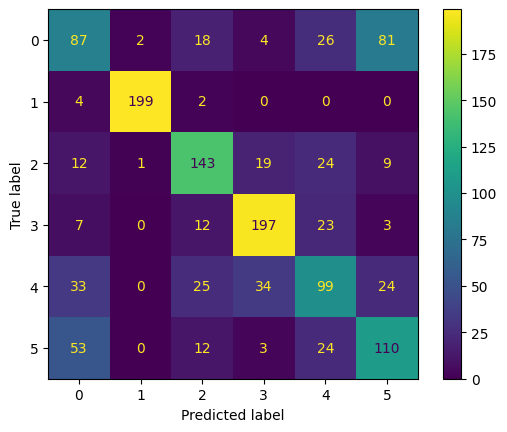

In [9]:
RandomForestClassifier(X_train, y_train, X_test, y_test)

## (3) Stochastic Gradient Descent

### GridSearchCV

In [10]:
def SGDGridSearch(X_train, y_train):
    #Parameters for GridSearchCV
    parameters = {'loss': ['hinge', 'log_loss'],
                  'penalty': ['l2', 'l1', 'elasticnet', None],
                  'max_iter': [100, 1000, 5000]}
    #GridSearchCV
    clf = GridSearchCV(estimator = linear_model.SGDClassifier(),
                       param_grid = parameters,
                       cv = 5,
                       n_jobs = 5,
                       verbose = 1)
    clf = clf.fit(X_train, y_train)
    print(clf.best_params_)

SGDGridSearch(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'loss': 'log_loss', 'max_iter': 1000, 'penalty': None}


### Stochastic Gradient Descent Classifier

In [11]:
def SGDClassifier(X_train, y_train, X_test, y_test):
    #SGDClassifier
    clf = linear_model.SGDClassifier(loss = 'log_loss',
                                     max_iter = 1000,
                                     penalty = None)
    clf = clf.fit(X_train, y_train)
    #Prediction
    predictions = clf.predict(X_test)
    #Prediction accuracy
    print(accuracy_score(y_test, predictions))
    #Confusion matrix
    confusion_matrix_result = confusion_matrix(y_test, predictions)
    cm_vis = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_result, 
                                    display_labels = clf.classes_)
    cm_vis.plot()

0.6031007751937985


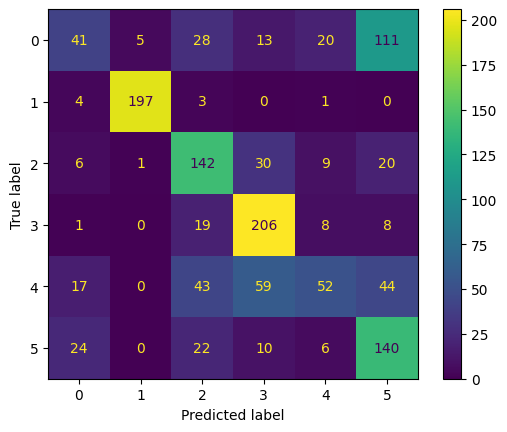

In [12]:
SGDClassifier(X_train, y_train, X_test, y_test)

## (4) K-Nearest Neighbors

### GridSearchCV

In [13]:
def KNNGridSearch(X_train, y_train):
    #Parameters for GridSearchCV
    parameters = {'n_neighbors': [2, 5, 10, 20],
                  'weights': ['uniform', 'distance', None],
                  'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
    #GridSearchCV
    clf = GridSearchCV(estimator = neighbors.KNeighborsClassifier(),
                       param_grid = parameters,
                       cv = 5,
                       n_jobs = 5,
                       verbose = 1)
    clf = clf.fit(X_train, y_train)
    print(clf.best_params_)

KNNGridSearch(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'algorithm': 'auto', 'n_neighbors': 20, 'weights': 'uniform'}


### K-Nearest Neighbors Classifier

In [14]:
def KNNClassifier(X_train, y_train, X_test, y_test):
    #SGDClassifier
    clf = neighbors.KNeighborsClassifier(n_neighbors = 2,
                                         algorithm = 'auto',
                                         weights = 'distance')
    clf = clf.fit(X_train, y_train)
    #Prediction
    predictions = clf.predict(X_test)
    #Prediction accuracy
    print(accuracy_score(y_test, predictions))
    #Confusion matrix
    confusion_matrix_result = confusion_matrix(y_test, predictions)
    cm_vis = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_result, 
                                    display_labels = clf.classes_)
    cm_vis.plot()

0.5124031007751938


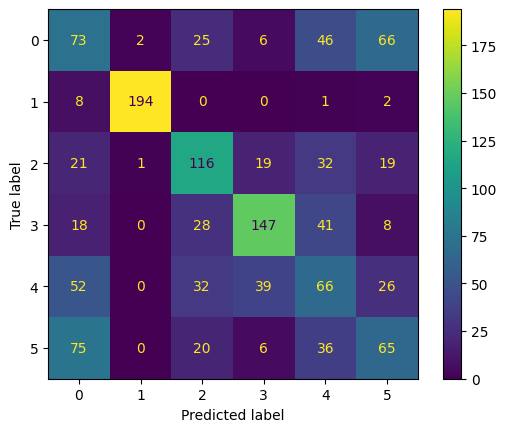

In [15]:
KNNClassifier(X_train, y_train, X_test, y_test)